In [1]:
import os, sys
import librosa
import plot
import numpy as np
import pandas as pd
import IPython.display as ipd
import novelty
import tempo
from scipy import signal
from matplotlib import pyplot as plt

In [2]:
Fs = 22050
song = os.path.join('songs', 'Dont ask me what is disco.mp3')
start = 12
end = 20
# plot.plot_wav_spectrogram(song, start=start*Fs, end=end*Fs)
# plot.plot_wav_spectrogram(song)

# x, Fs = librosa.load(song, Fs, offset=start, duration=end-start) 
x, Fs = librosa.load(song, Fs) 
x_duration = len(x)/Fs

N = 2048
w = signal.hann(N)

/home/gary/anaconda3/envs/FMP/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


In [3]:
librosa.beat.tempo(x, Fs, aggr)

array([143.5546875])

In [3]:
# x_h, x_p = novelty.HPSS(x, N, H=int(N/4), w='hann', Fs=Fs, lh_sec=0.2, lp_Hz=500)

# ipd.display(ipd.Audio(x_h, rate=Fs))
# ipd.display(ipd.Audio(x_p, rate=Fs))

# # x = x_p

We can also try subband spectral-based novelty function

In [4]:
nov_dic = {}

nov, Fs_nov = novelty.compute_novelty_energy(x, Fs=Fs, gamma=None)
nov_dic.update( {0 : [nov, Fs_nov, r'Energy-based novelty function (Fs = %d)'%Fs_nov]} )

nov, Fs_nov = novelty.compute_novelty_energy(x, Fs=Fs, gamma=1000)
nov_dic.update( {1 : [nov, Fs_nov, 'Energy-based novelty function with compression (Fs = %d)'%Fs_nov]} )

nov, Fs_nov = novelty.compute_novelty_spectrum(x, Fs=Fs)
nov_dic.update( {2 : [nov, Fs_nov, 'Spectral-based novelty function (Fs = %d)'%Fs_nov]} )

nov, Fs_nov = novelty.compute_novelty_phase(x, Fs=Fs)
nov_dic.update( {3 : [nov, Fs_nov, 'Phase-based novelty function (Fs = %d)'%Fs_nov]} )

nov, Fs_nov =novelty.compute_novelty_complex(x, Fs=Fs)
nov_dic.update( {4 : [nov, Fs_nov, 'Complex-domain novelty function (Fs = %d)'%Fs_nov]} )

# for k in nov_dic:
#     fig, ax, line = plot.plot_signal(nov_dic[k][0], Fs=nov_dic[k][1], 
#                         color='k', title=nov_dic[k][2])  
#     novelty.sonify_noveltyCurve(nov_dic[k][0], x, Fs, nov_dic[k][1])

In [5]:
cmap = plot.compressed_gray_cmap(alpha=1)

Fs_out = 100
sigma = 2
nov_matrix_smooth, Fs_out = novelty.average_nov_dic(nov_dic, time_max_sec=x_duration, Fs_out=Fs_out, sigma=sigma)

# plt.figure(figsize=[25,5])
# ax = plt.subplot(1,1,1)
# im = ax.imshow(nov_matrix_smooth, cmap=cmap, aspect='auto', clim=[0,1],
#           extent=[0, x_duration, nov_matrix_smooth.shape[0]+0.5, 0.5])
# ax.set_xlabel('Time (seconds)')
# ax.set_yticks([1,2,3,4,5,6])
# ax.set_yticklabels([r'Energy', r'EnergyLog', r'Spectral', r'Phase', r'Complex', r'Average'])

# plt.colorbar(im)
# plt.tight_layout()

# novelty.sonify_noveltyCurve(nov_matrix_smooth[5,:], x, Fs, Fs_out)

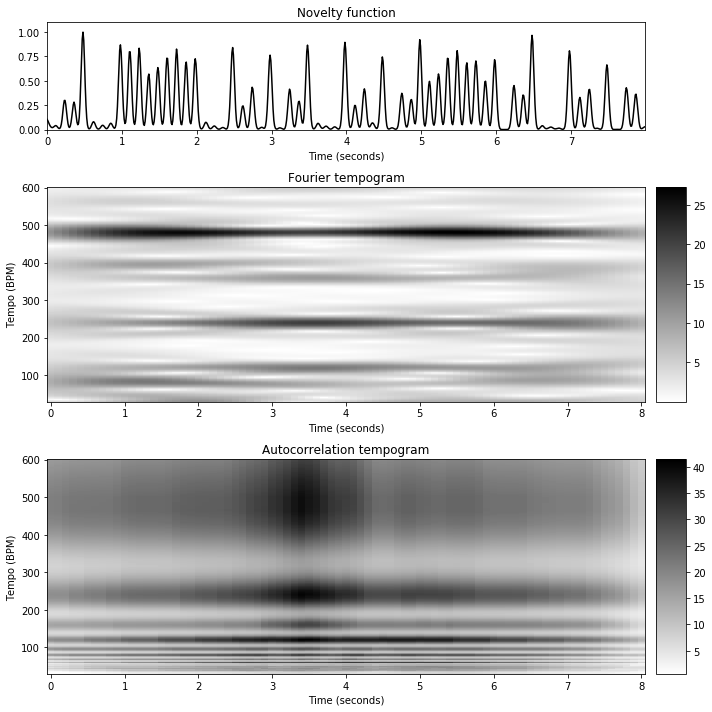

In [6]:
nov = nov_matrix_smooth[2]
Fs_nov = Fs_out

fig, ax = plt.subplots(3, 2, gridspec_kw={'width_ratios': [1, 0.05], 
                                          'height_ratios': [1, 2, 2]}, figsize=(10,10))    
plot.plot_signal(nov, Fs_nov, ax=ax[0,0], color='k', title='Novelty function')
ax[0,1].set_axis_off()

# Fourier Tempogram
X, T_coef, F_coef_BPM = tempo.compute_tempogram_Fourier(nov, Fs_nov, N=500, H=10)
tempogram_F = np.abs(X)
plot.plot_matrix(tempogram_F, T_coef=T_coef, F_coef=F_coef_BPM, ax=[ax[1,0], ax[1,1]], 
                    title='Fourier tempogram', ylabel='Tempo (BPM)', colorbar=True)

# Autocorrelation Tempogram
tempogram_A, T_coef, F_coef, A, F_coef_lag = tempo.compute_tempogram_autocorr(nov, Fs_nov, N=500, H=10)
plot.plot_matrix(tempogram_A, T_coef=T_coef, F_coef=F_coef, ax=[ax[2,0], ax[2,1]], 
                    title='Autocorrelation tempogram', ylabel='Tempo (BPM)', colorbar=True)

plt.tight_layout()

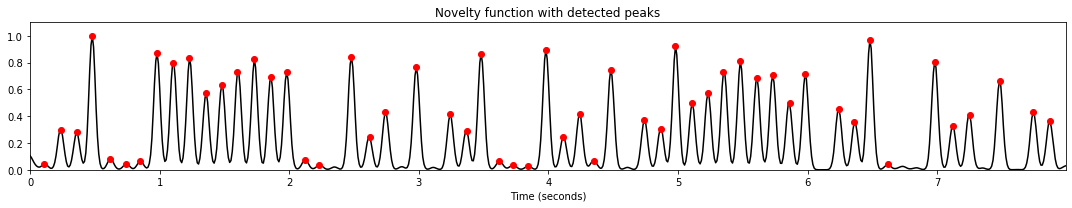

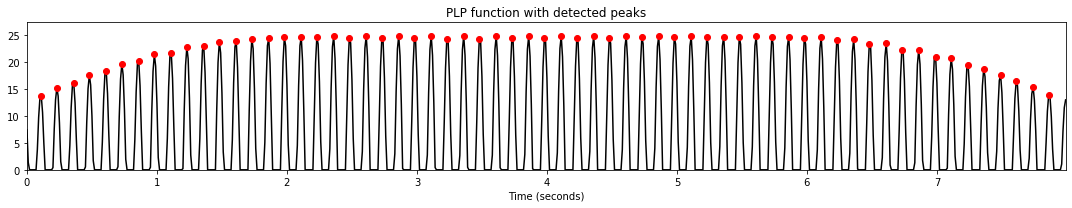

In [7]:
L = len(nov)
nov_PLP = tempo.compute_PLP(X, Fs_nov, L, N=500, H=10)

t_nov = np.arange(nov.shape[0]) / Fs_nov
peaks, properties = signal.find_peaks(nov, prominence=0.02)
peaks_sec = t_nov[peaks]
plot.plot_signal(nov, Fs_nov, color='k', title='Novelty function with detected peaks');
plt.plot(peaks_sec, nov[peaks], 'ro')
plt.show()
x_peaks = librosa.clicks(peaks_sec, sr=Fs, click_freq=1000, length=len(x))
ipd.display(ipd.Audio(x + x_peaks, rate=Fs))

peaks, properties = signal.find_peaks(nov_PLP, prominence=0.02)
peaks_sec = t_nov[peaks]
plot.plot_signal(nov_PLP, Fs_nov, color='k', title='PLP function with detected peaks');
plt.plot(peaks_sec, nov_PLP[peaks], 'ro')
plt.show()
x_peaks = librosa.clicks(peaks_sec, sr=Fs, click_freq=1000, length=len(x))
ipd.display(ipd.Audio(x + x_peaks, rate=Fs))

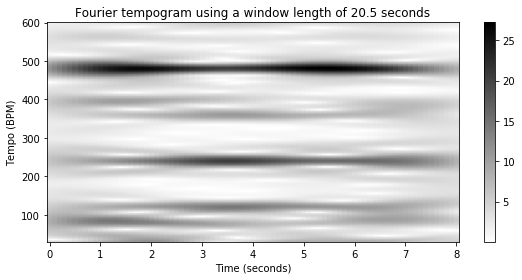

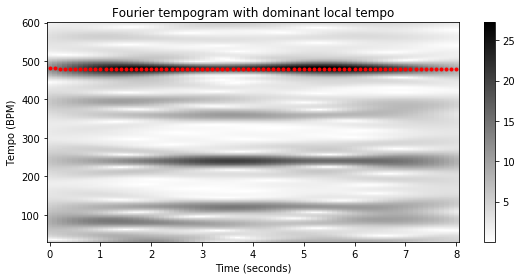

In [8]:
title = 'Fourier tempogram using a window length of %0.1f seconds'%(N/Fs_nov)
plot.plot_matrix(tempogram_F, T_coef=T_coef, F_coef=F_coef_BPM, figsize=(8,4),
                     title=title, ylabel='Tempo (BPM)', colorbar=True);
fig, ax, im = plot.plot_matrix(tempogram_F, T_coef=T_coef, F_coef=F_coef_BPM, figsize=(8,4),
                     title='Fourier tempogram with dominant local tempo', ylabel='Tempo (BPM)', colorbar=True)
coef_k = np.argmax(tempogram_F, axis=0)
ax[0].plot(T_coef, F_coef_BPM[coef_k], 'r.')

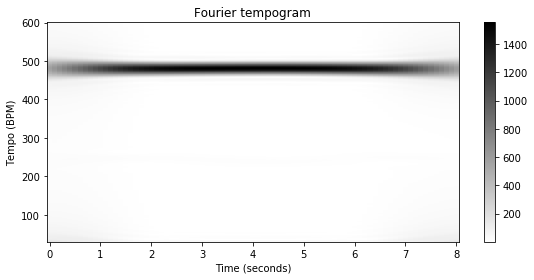

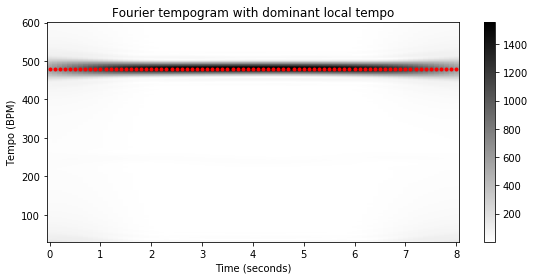

In [9]:
# Fourier Tempogram
X, T_coef, F_coef_BPM = tempo.compute_tempogram_Fourier(nov_PLP, Fs=Fs_out, N=500, H=10)
tempogram_F = np.abs(X)
plot.plot_matrix(tempogram_F, T_coef=T_coef, F_coef=F_coef_BPM, figsize=(8,4),
                    title='Fourier tempogram', ylabel='Tempo (BPM)', colorbar=True)

fig, ax, im = plot.plot_matrix(tempogram_F, T_coef=T_coef, F_coef=F_coef_BPM, figsize=(8,4),
                     title='Fourier tempogram with dominant local tempo', ylabel='Tempo (BPM)', colorbar=True)
coef_k = np.argmax(tempogram_F, axis=0)
ax[0].plot(T_coef, F_coef_BPM[coef_k], 'r.')

In [10]:
BPM = np.mean(F_coef_BPM[coef_k])
beat_ref = (60/BPM) * Fs_nov

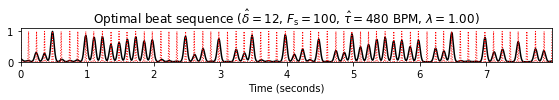

In [11]:
#Dynamic Programming Beat Tracking
tempo.compute_plot_sonify_beat(nov, Fs_nov, x=x, Fs=22050, beat_ref=beat_ref, factor=1, figsize=(8,1.5))

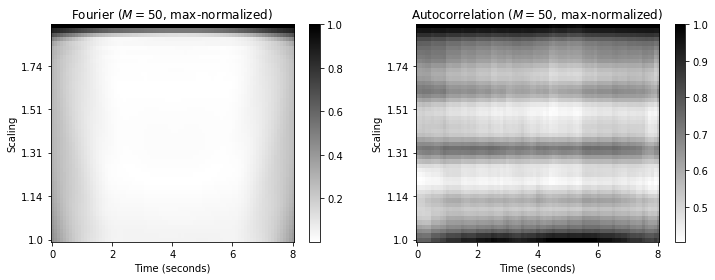

In [12]:
M=50
title_F = r'Fourier ($M=%d$, max-normalized)'%M
title_A = r'Autocorrelation ($M=%d$, max-normalized)'%M
tempo.plot_tempogram_Fourier_autocor(tempogram_F, tempogram_A, T_coef, F_coef_BPM, 
                               M, title_F, title_A, norm='max')